In [1]:
%%time
%matplotlib inline
import importlib
import new_import  
importlib.reload(new_import)
from new_import import *

CPU times: user 8.18 s, sys: 5.96 s, total: 14.1 s
Wall time: 8 s


In [2]:
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()
client

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.f54542a2f3194889937284eda406b204/status,


In [3]:
date_range =  ('2022-09-01', '2023-10-01')
#date_range = ('2023-05-01', '2024-06-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

coordinates = (longtitude_range, latitude_range)

In [4]:
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

<xarray.Dataset>
Dimensions:      (time: 32, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)

VBox()

In [6]:
average_vh = calculate_average(dsvh, time_pattern='1M')
progress(average_vh)

VBox()

In [7]:
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

VBox()

In [9]:
# calculate NDVI
dsNDVI = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = dsNDVI["NDVI"]

In [10]:
# calculate average NDVI
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

VBox()

In [11]:
%%time
average_vh.compute()
average_vv.compute()
average_ndvi = average_ndvi.compute()

CPU times: user 75.1 ms, sys: 46.9 ms, total: 122 ms
Wall time: 299 ms


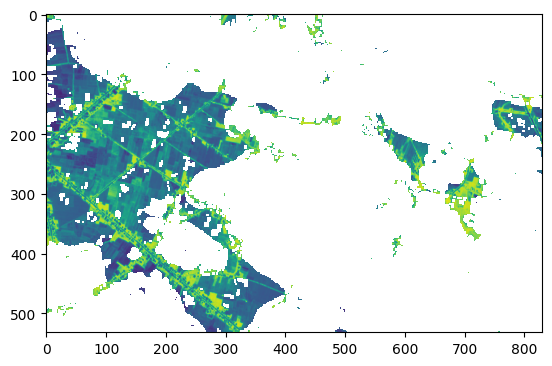

In [12]:
plt.imshow(average_ndvi.isel(time=0), vmin=None, vmax=None)

LOAD FILL CLOUD MODEL

In [14]:
fill_nan_model = joblib.load("model_train/gb_cloud.pkl")
mask = ~np.isnan(average_ndvi)

In [15]:
X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(X_pred)
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

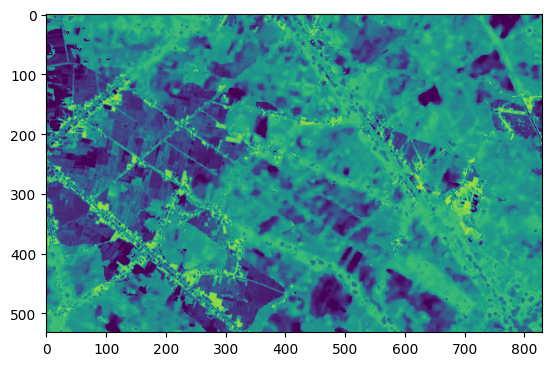

In [16]:
plt.imshow(average_ndvi.isel(time=0), vmin=0, vmax=1)

LOAD CLASSIFY MODEL

In [18]:
classif_path = "model_train/rf_classify.pkl"
classify_model = joblib.load(classif_path)

In [19]:
data_array = predict(classify_model, data_sen2.rio.crs, average_ndvi, average_vh, average_vv)

DRAW IMAGE

/tmp/ipykernel_23645/1099579276.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


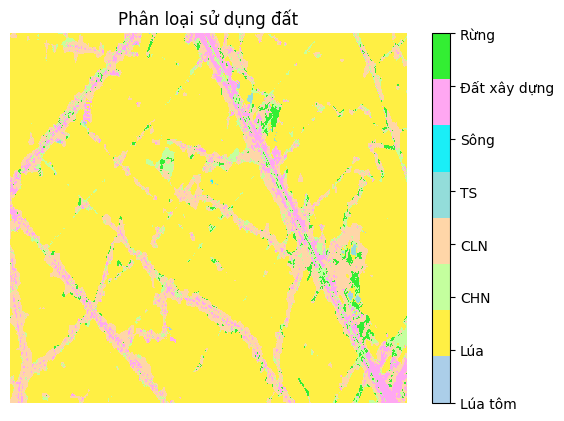

In [18]:
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

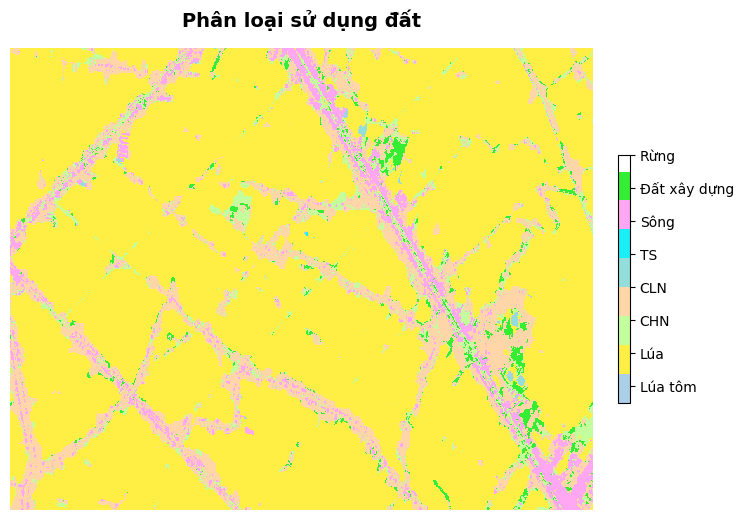

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colors and labels
colors = [
    "#abcee9",  # Lúa tôm
    "#ffef44",  # Lúa
    "#c4ff9e",  # CHN
    "#ffd6a8",  # CLN
    "#93ddda",  # TS
    "#1aeef7",  # Sông
    "#ffa7f2",  # Đất xây dựng
    "#33ee33"   # Rừng
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

# Create a custom colormap
cmap = ListedColormap(colors)

# Plot the data array
fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size for better visualization
img = data_array.plot(cmap=cmap, add_colorbar=False, ax=ax)

# Customize the colorbar
cbar = plt.colorbar(img, ax=ax, fraction=0.02, pad=0.04)  # Adjust size and position
cbar.set_ticks([i + 0.5 for i in range(len(labels))])  # Center ticks between colors
cbar.set_ticklabels(labels)  # Set custom labels
cbar.ax.tick_params(labelsize=10)  # Adjust label font size

# Add title and remove axes
ax.set_title("Phân loại sử dụng đất", fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

# Show the plot
plt.show()


In [26]:
path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

region_result = cut_according_shp(path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [21]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                  # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),    # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [22]:
unique_values = np.unique(region_result.values[~np.isnan(region_result.values)])
print("Các giá trị duy nhất trong mảng (bỏ qua NaN):", unique_values)

Các giá trị duy nhất trong mảng (bỏ qua NaN): [0. 1. 2. 3. 4. 5. 6. 7.]


In [28]:
# region_result.rio.to_raster("output/classified_results/classified_rf.tif")
region_result.rio.to_raster("KetQuaPhanLoaiDat_15-09.tif")

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/usr/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._handle_read()
  File "/env/lib/python3.10/site-packages/tornado/iostream.py", line 1454, in _handle_read
    self._do_ssl_ha

###############################
TEST IN 300 POINTS###############################


In [63]:
geo_path = "input/train_points/300/ThuanHoa_DKS_Kappa_new.shp"
points_label = load_data_geo(geo_path)
points_label.head()

,STT,LULC,Code,geometry
0,1,Dat xay dung,6,POINT Z (601020.539 1068835.423 0.000)
1,2,CLN,3,POINT Z (600992.765 1068892.073 0.000)
2,3,Dat xay dung,6,POINT Z (600983.261 1068711.965 0.000)
3,4,Lua,1,POINT Z (600885.708 1069333.342 0.000)
4,5,Dat xay dung,6,POINT Z (600129.865 1069351.996 0.000)


In [64]:
def extract_data_point(train, average_ndvi, dsvh, dsvv):
    loaded_datasets = {}
    for idx, point in train.iterrows():
        key = f"point_{idx + 1}"
        try:
            ndvi_data = average_ndvi.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            vh_data = dsvh.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            vv_data = dsvv.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values
            loaded_datasets[key] = {
                "data": np.stack((ndvi_data, vh_data, vv_data), axis=0),
                "label": point.Code
            }
        except Exception as e:
            # Handle the exception if necessary
            print(f"Error at point {key}: {e}")
    return loaded_datasets

In [65]:
data_points = extract_data_point(points_label, average_ndvi_filled, average_vh, average_vv)
features, labels = create_dataset(data_points)

In [66]:
preds = classify_model.predict(features)

In [67]:
acc = accuracy_score(preds, labels)
print(f"Accuracy: {acc*100} %")

Accuracy: 54.18060200668896 %


In [ ]:
client.close()
cluster.close()